<a href="https://colab.research.google.com/github/iAAA-event/iAAA-MRI-Contest-Image/blob/main/iaaa_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare Environment

In [1]:
! pip install SimpleITK
! pip install pydicom
! pip install "numpy<2" "tensorflow==2.15" "keras==2.15"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.4/52.4 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 73.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.0 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.0
    Uninstalling ml-dtypes-0.4.0:
      Successfully uninstalled ml-dtypes-0.4.0
  Attempting uninstall: keras
    Found existing installati

Clone the repository:

In [2]:
!git clone https://github.com/iAAA-event/iAAA-MRI-Challenge.git

Cloning into 'iAAA-MRI-Challenge'...
remote: Enumerating objects: 20, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 20 (delta 4), reused 9 (delta 3), pack-reused 9 (from 1)
Receiving objects: 100% (20/20), 135.10 MiB | 16.97 MiB/s, done.
Resolving deltas: 100% (5/5), done.


Unzip data:

In [3]:
!unzip /content/iAAA-MRI-Challenge/MRI_Labeling_normal_abnormal_SPI_p0_s0.zip -d ~/data

Archive:  /content/iAAA-MRI-Challenge/MRI_Labeling_normal_abnormal_SPI_p0_s0.zip
   creating: /root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/
  inflating: /root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/labels_dictionary.json  
   creating: /root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/data/
   creating: /root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/data/1.3.46.670589.11.10042.5.0.6048.2024030714370454603/
  inflating: /root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/data/1.3.46.670589.11.10042.5.0.6048.2024030714370454603/1.3.46.670589.11.10042.5.0.6048.2024030714374551656.dcm  
  inflating: /root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/data/1.3.46.670589.11.10042.5.0.6048.2024030714370454603/1.3.46.670589.11.10042.5.0.6048.2024030714374554657.dcm  
  inflating: /root/data/MRI_Labeling_normal_abnormal_SPI_p0_s0/data/1.3.46.670589.11.10042.5.0.6048.2024030714370454603/1.3.46.670589.11.10042.5.0.6048.2024030714374557658.dcm  
  inflating: /root/data/MRI_Labeling_normal

# Prepare Data

Define paths:

In [4]:
from pathlib import Path


ROOT_DATA_DIR = Path('~/data/MRI_Labeling_normal_abnormal_SPI_p0_s0').expanduser().absolute()
DATA_DIR = ROOT_DATA_DIR / 'data'
LABELS_PATH = ROOT_DATA_DIR / 'labels.csv'
PREPARED_DATA_DIR = Path('~/prepared_data').expanduser().absolute()

Define helper functions:

In [5]:
from typing import Optional

import numpy as np
import pydicom
import SimpleITK as sitk
from PIL import Image


def read_dicom_series(study_path: Path, series_instance_uid: Optional[str] = None) -> np.ndarray:
    """Reads the dicom series and returns the rendered pixel-array, header and dicom file paths.

    Notes:
        - returned array is in haunsfield uints, you have to take care of windowing
    """

    if series_instance_uid is None:
        series_id = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(study_path))[0]
    else:
        series_id = series_instance_uid

    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(study_path), series_id)

    headers = list()
    for fn in series_file_names:
        headers.append(pydicom.dcmread(str(fn), stop_before_pixels=True))

    volume = sitk.ReadImage(
        series_file_names, sitk.sitkInt32
    )
    volume = np.array(sitk.GetArrayFromImage(volume), dtype=np.float32)

    if all([i.get('InstanceNumber') is not None for i in headers]):
        slice_number_tag = 'InstanceNumber'
    elif all([i.get('InstanceNumber') is not None for i in headers]):  # in earlier versions of Dicom
        slice_number_tag = 'ImageNumber'
    else:
        slice_number_tag = None

    if slice_number_tag is not None:
        sorted_headers = sorted(headers, key=lambda x: int(x.get(slice_number_tag)))
        file_name_to_index_mapper = {k: v for v, k in enumerate(series_file_names)}
        sorted_file_names = sorted(
            series_file_names,
            key=lambda x: int(headers[file_name_to_index_mapper[x]].get(slice_number_tag))
        )
    else:
        sorted_headers = headers
        sorted_file_names = series_file_names

    ret = {
        'array': volume,
        'headers': sorted_headers,
        'dcm_paths': sorted_file_names
    }
    return ret


def apply_windowing(series: np.ndarray,
                    window_center: int,
                    window_width: int) -> np.ndarray:
    """Returns an array for given window.

    Args:
        series: numpy array of shape (n_slices, h, w) or (h, w) in haunsfield units.
        window_center: for example, brain window's center is 40
        window_width: for example, brain window's width is 80

    Returns:
        numpy array of shape (n_sclies, h, w) or (h, w) in range(0, 1)

    """

    w_min = int(window_center - (window_width / 2))
    w_max = int(window_center + (window_width / 2))

    clipped = np.clip(series, w_min, w_max)
    windowed = (clipped - w_min) / (w_max - w_min)

    return windowed


def apply_windowing_using_header(arr: np.ndarray, header: pydicom.FileDataset) -> np.ndarray:
    """This function returns an array for windows found in windowing dicom tags.

    Args:
        arr: numpy array of shape (h, w) in haunsfield units.
        header: dicom header containing ``WindowCenter`` and ``WindowWidth``

    Returns:
        numpy array of shape (h, w) in range(0, 1)
    """

    window_center = header.get('WindowCenter')
    window_width = header.get('WindowWidth')

    return apply_windowing(arr, window_center, window_width)


def apply_windowing_using_header_on_series(series: np.ndarray, headers: list[pydicom.FileDataset]) -> np.ndarray:
    """This function returns an array for windows found in windowing dicom tags.

    Args:
        series: numpy array of shape (num_slices, h, w) in haunsfield units.
        headers: dicom header containing ``WindowCenter`` and ``WindowWidth``

    Returns:
        numpy array of shape (h, w) in range(0, 1)
    """

    windowed_series = list()
    for i, header in enumerate(headers):
        window_center = header.get('WindowCenter')
        window_width = header.get('WindowWidth')
        windowed_series.append(apply_windowing(series[i], window_center, window_width))

    return np.array(windowed_series)


Read annotations:

In [6]:
import pandas as pd


annotations = pd.read_csv(LABELS_PATH).drop(['normal', 'corrupted'], axis=1)
annotations.rename(
    {
        "abnormal": "prediction"
    },
    axis=1,
    inplace=True
)
annotations

,SeriesInstanceUID,prediction
0,1.3.46.670589.11.10042.5.0.6048.20240307143704...,0
1,1.3.46.670589.11.10042.5.0.6048.20240307143746...,0
2,1.3.46.670589.11.10042.5.0.6048.20240307143846...,0
3,1.3.46.670589.11.10042.5.0.4776.20240217030800...,0
4,1.3.46.670589.11.10042.5.0.4776.20240217030846...,0
...,...,...
85,1.3.46.670589.11.10042.5.0.1412.20240205021022...,0
86,1.3.46.670589.11.10042.5.0.1412.20240205021123...,0
87,1.3.46.670589.11.10042.5.0.6596.20240121013023...,0
88,1.3.46.670589.11.10042.5.0.6596.20240121012857...,0


Visualize data:

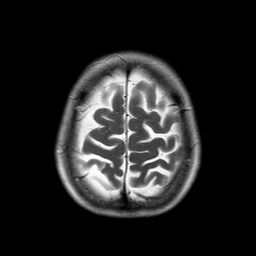

In [7]:
series_instance_uid = '1.3.46.670589.11.10042.5.0.6840.2023122400165489007' # @param {type:"string"}
slice_index = 15 # @param {type:"integer"}

study_path = DATA_DIR / series_instance_uid
series = read_dicom_series(study_path)

series_array = series['array']

slice_array = series_array[slice_index]
slice_header = series['headers'][slice_index]
windowed_slice_array = apply_windowing_using_header(slice_array, slice_header)

Image.fromarray((windowed_slice_array * 255).astype('uint8'))

Examine shapes of raw data:

In [8]:
study_paths = [i for i in DATA_DIR.iterdir() if i.is_dir() and len(list(i.glob('*.dcm'))) > 0]

shapes = list()
for p in study_paths:
    series = read_dicom_series(p)
    shapes.append(series['array'].shape)

print(set(shapes))

{(16, 288, 288), (20, 256, 256), (18, 288, 288), (18, 256, 256), (20, 288, 288), (16, 256, 256), (16, 320, 320), (20, 384, 384)}


Split to training/validation sub-sets:

In [9]:
from sklearn.model_selection import train_test_split


validation_size = 0.3

stratify_df = annotations['prediction']
training_df, validation_df = train_test_split(
    annotations,
    test_size=validation_size,
    stratify=annotations['prediction'],
    random_state=7
)

We will clip all Dicom series to have 16 slices and resize to (256, 256), i.e. the final prepared data shape will be (16, 256, 256):

In [10]:
import tensorflow as tf
from tqdm import tqdm


def prepare_data(df: pd.DataFrame, split: str, target_h: int, target_w: int, expected_num_slices: int):
    prepared_data_dir_for_split = PREPARED_DATA_DIR / split
    prepared_data_dir_for_split.mkdir(parents=True, exist_ok=True)
    prepared_data_paths = list()
    for ind, row in tqdm(df.iterrows()):
        siuid = row['SeriesInstanceUID']
        study_path = DATA_DIR / siuid
        series = read_dicom_series(study_path)
        windowed_series = apply_windowing_using_header_on_series(series['array'], series['headers'])

        if (windowed_series.shape[1] != target_h) or (windowed_series.shape[2] != target_w):
            arr = np.squeeze(tf.image.resize_with_pad(np.expand_dims(windowed_series, axis=-1), target_h, target_w))
        else:
            arr = windowed_series

        if len(arr) != 16:
            remainder = len(arr) - 16
            arr = arr[int(remainder / 2): 16 + int(remainder / 2)]

        prepared_path = prepared_data_dir_for_split / f'{siuid}.npy'
        with open(prepared_path, 'wb') as f:
            np.save(f, arr)
        prepared_data_paths.append(prepared_path)

    df['prepared_path'] = prepared_data_paths


expected_num_slices = 16
target_h = 256
target_w = 256

prepare_data(training_df, 'training', target_h, target_w, expected_num_slices)
prepare_data(validation_df, 'validation', target_h, target_w, expected_num_slices)

63it [00:28,  2.19it/s]
27it [00:11,  2.43it/s]


Create datasets:

In [11]:
def read_npy_file(item):
    data = np.load(item.decode())
    return np.expand_dims(data.astype(np.float32), axis=-1)


def create_ds(df: pd.DataFrame, batch_size: int) -> tf.data.Dataset:
    paths = [str(i) for i in df['prepared_path']]
    volumes = tf.data.Dataset.from_tensor_slices(paths).map(lambda item: tf.numpy_function(read_npy_file, [item], [tf.float32,])[0])
    labels = tf.data.Dataset.from_tensor_slices(df['prediction'].values)
    zipped = tf.data.Dataset.zip(volumes, labels)
    ds = zipped.shuffle(len(paths), seed=7).batch(batch_size).repeat()
    return ds


BATCH_SIZE = 4

training_ds = create_ds(training_df, BATCH_SIZE)
n_iter_training = (len(training_df) // BATCH_SIZE) + int((len(training_df) % BATCH_SIZE) > 0)
validation_ds = create_ds(validation_df, BATCH_SIZE)
n_iter_validation = (len(validation_df) // BATCH_SIZE) + int((len(validation_df) % BATCH_SIZE) > 0)

tr_gen = training_ds.as_numpy_iterator()
val_gen = validation_ds.as_numpy_iterator()

Visualize the dataset:

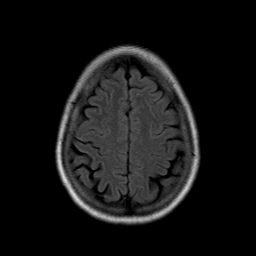

In [12]:
xb, yb = next(tr_gen)

batch_ind = 0
slice_ind = 13
Image.fromarray((xb[batch_ind, slice_ind, :, :, 0] * 255).astype('uint8'))

# Prepare Model

In [13]:
import tensorflow.keras.layers as layers
import tensorflow.keras as keras


def create_model(expected_num_slices: int, target_h: int, target_w: int) -> keras.Model:
    inputs = keras.Input((expected_num_slices, target_h, target_w, 1))

    x = layers.Conv3D(filters=64, kernel_size=3, padding='same', activation="relu")(inputs)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=64, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=128, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Conv3D(filters=256, kernel_size=3, padding='same', activation="relu")(x)
    x = layers.MaxPool3D(pool_size=2)(x)
    x = layers.BatchNormalization()(x)

    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)
    return model


expected_num_slices = 16
target_h = 256
target_w = 256

model = create_model(expected_num_slices, target_h, target_w)

metrics = [
    keras.metrics.SensitivityAtSpecificity(0.95),
    keras.metrics.SpecificityAtSensitivity(0.95),
    keras.metrics.AUC(name='auc')
]
loss = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(0.001)

model.compile(loss=loss, metrics=metrics, optimizer=optimizer)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 16, 256, 256, 1   0         
                             )]                                  
                                                                 
 conv3d (Conv3D)             (None, 16, 256, 256, 64   1792      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3  (None, 8, 128, 128, 64)   0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 8, 128, 128, 64)   256       
 Normalization)                                                  
                                                                 
 conv3d_1 (Conv3D)           (None, 8, 128, 128, 64)   110656

# Training

In [14]:
checkpoints_dir = Path('checkpoints')
checkpoints_dir.mkdir(exist_ok=True)

to_track = 'val_auc'
checkpoint_path = str(checkpoints_dir) + "/sm-{epoch:04d}" + "-{" + to_track + ":4.5f}"

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, save_best_only=False, save_weights_only=False)
]

history = model.fit(
    training_ds,
    steps_per_epoch=n_iter_training,
    validation_data=validation_ds,
    validation_steps=n_iter_validation,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10
16/16 [==============================] - 28s 867ms/step - loss: 0.5179 - sensitivity_at_specificity: 0.1250 - specificity_at_sensitivity: 0.1636 - auc: 0.5705 - val_loss: 0.8873 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - val_auc: 0.2826
Epoch 2/10
16/16 [==============================] - 8s 510ms/step - loss: 0.4403 - sensitivity_at_specificity: 0.2500 - specificity_at_sensitivity: 0.1273 - auc: 0.5534 - val_loss: 0.6215 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.2609 - val_auc: 0.5761
Epoch 3/10
16/16 [==============================] - 8s 528ms/step - loss: 0.4739 - sensitivity_at_specificity: 0.0000e+00 - specificity_at_sensitivity: 0.0000e+00 - auc: 0.4636 - val_loss: 0.8257 - val_sensitivity_at_specificity: 0.0000e+00 - val_specificity_at_sensitivity: 0.0000e+00 - val_auc: 0.2120
Epoch 4/10
16/16 [==============================] - 8s 493ms/step - loss: 0.3417 - sensitivity_at_specifici

# Export

Export the best model:

In [15]:
import typing
import shutil


def get_best_checkpoint(checkpoints_dir: Path, export_mode: str) -> typing.List[typing.Dict]:
    checkpoints = get_checkpoints_info(checkpoints_dir)

    if export_mode == 'min':
        selected_model = min(checkpoints, key=lambda x: x['value'])
    else:
        selected_model = max(checkpoints, key=lambda x: x['value'])
    return selected_model


def get_checkpoints_info(checkpoints_dir: Path) -> typing.List[typing.Dict]:
    """Returns info about checkpoints.

    Returns:
        A list of dictionaries related to each checkpoint:
            {'epoch': int, 'path': pathlib.Path, 'value': float}

    """

    checkpoints = _get_checkpoints(checkpoints_dir)

    ckpt_info = list()
    for cp in checkpoints:
        if cp.name.endswith('.keras'):
            splits = str(cp.name).split('.keras')[0].split('-')
        else:
            splits = str(cp.name).split('-')
        epoch = int(splits[1])
        metric_value = float(splits[2])
        ckpt_info.append({'path': cp, 'epoch': epoch, 'value': metric_value})
    return ckpt_info


def _get_checkpoints(checkpoints_dir: Path) -> typing.List[Path]:
    """Returns a list of paths to folders containing a ``saved_model.pb``"""

    checkpoints = list()
    for item in checkpoints_dir.iterdir():
        if any(item.glob('saved_model.pb')) or item.name.endswith('.keras'):
            checkpoints.append(item)

    return checkpoints


export_dir = Path('exported')
export_dir.mkdir(exist_ok=True)

best_checkpoint = get_best_checkpoint(checkpoints_dir, 'max')
shutil.copytree(best_checkpoint['path'], export_dir / 'model')

PosixPath('exported/model')

Create a `sumbission.py` file, with following specifications:
- takes two command-line arguments:
    - `data_dir`: path to data directory, which consists of folders of Dicom files, each one corresponding to a Dicom series
    - `predictions_file_path`: path to a `.csv` file which is expected to be generated by your script, and has to contain following columns:
        - `SeriesInstanceUID` (str)
        - `prediction` (float): model's raw prediction
- reads the model file which you have included in your final `.zip` file

let's create our submission file as `exported/submission.py`:

In [ ]:
"""
filename: ``submission.py``
execution: python submission.py --data-dir /path/to/data-dir --predictions-file-path submission.csv
"""
from typing import Optional

import numpy as np
import pandas as pd
import tensorflow.keras as keras
import pydicom
import SimpleITK as sitk
from PIL import Image
import click


HERE = Path(__file__).absolute().resolve().parent


def read_dicom_series(study_path: Path, series_instance_uid: Optional[str] = None) -> np.ndarray:
    """Reads the dicom series and returns the rendered pixel-array, header and dicom file paths.

    Notes:
        - returned array is in haunsfield uints, you have to take care of windowing
    """

    if series_instance_uid is None:
        series_id = sitk.ImageSeriesReader.GetGDCMSeriesIDs(str(study_path))[0]
    else:
        series_id = series_instance_uid

    series_file_names = sitk.ImageSeriesReader.GetGDCMSeriesFileNames(str(study_path), series_id)

    headers = list()
    for fn in series_file_names:
        headers.append(pydicom.dcmread(str(fn), stop_before_pixels=True))

    volume = sitk.ReadImage(
        series_file_names, sitk.sitkInt32
    )
    volume = np.array(sitk.GetArrayFromImage(volume), dtype=np.float32)

    if all([i.get('InstanceNumber') is not None for i in headers]):
        slice_number_tag = 'InstanceNumber'
    elif all([i.get('InstanceNumber') is not None for i in headers]):  # in earlier versions of Dicom
        slice_number_tag = 'ImageNumber'
    else:
        slice_number_tag = None

    if slice_number_tag is not None:
        sorted_headers = sorted(headers, key=lambda x: int(x.get(slice_number_tag)))
        file_name_to_index_mapper = {k: v for v, k in enumerate(series_file_names)}
        sorted_file_names = sorted(
            series_file_names,
            key=lambda x: int(headers[file_name_to_index_mapper[x]].get(slice_number_tag))
        )
    else:
        sorted_headers = headers
        sorted_file_names = series_file_names

    ret = {
        'array': volume,
        'headers': sorted_headers,
        'dcm_paths': sorted_file_names
    }
    return ret


def apply_windowing(series: np.ndarray,
                    window_center: int,
                    window_width: int) -> np.ndarray:
    """Returns an array for given window.

    Args:
        series: numpy array of shape (n_slices, h, w) or (h, w) in haunsfield units.
        window_center: for example, brain window's center is 40
        window_width: for example, brain window's width is 80

    Returns:
        numpy array of shape (n_sclies, h, w) or (h, w) in range(0, 1)

    """

    w_min = int(window_center - (window_width / 2))
    w_max = int(window_center + (window_width / 2))

    clipped = np.clip(series, w_min, w_max)
    windowed = (clipped - w_min) / (w_max - w_min)

    return windowed


def apply_windowing_using_header_on_series(series: np.ndarray, headers: list[pydicom.FileDataset]) -> np.ndarray:
    """This function returns an array for windows found in windowing dicom tags.

    Args:
        series: numpy array of shape (num_slices, h, w) in haunsfield units.
        headers: dicom header containing ``WindowCenter`` and ``WindowWidth``

    Returns:
        numpy array of shape (h, w) in range(0, 1)
    """

    windowed_series = list()
    for i, header in enumerate(headers):
        window_center = header.get('WindowCenter')
        window_width = header.get('WindowWidth')
        windowed_series.append(apply_windowing(series[i], window_center, window_width))

    return np.array(windowed_series)


@click.command()
@click.option('--data-dir', type=Path)
@click.option('--predictions-file-path', type=Path)
def main(data_dir: Path, predictions_file_path: Path):
    series_instance_uid_list = [i.name for i in data_dir.iterdir() if i.is_dir()]
    model = keras.models.load_model(str(HERE / 'model'))

    predictions = list()
    for siuid in series_instance_uid_list:
        study_path = DATA_DIR / siuid
        series = read_dicom_series(study_path)
        windowed_series = apply_windowing_using_header_on_series(series['array'], series['headers'])

        if (windowed_series.shape[1] != target_h) or (windowed_series.shape[2] != target_w):
            arr = np.squeeze(tf.image.resize_with_pad(np.expand_dims(windowed_series, axis=-1), target_h, target_w))
        else:
            arr = windowed_series

        if len(arr) != 16:
            remainder = len(arr) - 16
            arr = arr[int(remainder / 2): 16 + int(remainder / 2)]

        prediction = model.predict(np.expand_dims(arr, axis=(0, -1)))[0][0]
        predictions.append(prediction)

    predictions_df = pd.DataFrame({'SeriesInstanceUID': series_instance_uid_list, 'prediction': predictions})
    predictions_df.to_csv(predictions_file_path)


if __name__ == "__main__":
    main()


Now make a zip file from `exported` and upload it to evaluation platform.

In [ ]:
! zip -r exported.zip exported/ -x exported/.ipynb_checkpoints/